In [32]:
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
from IPython.display import display

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

from env import host, user, password
import os

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

In [2]:
url = get_db_url("grocery_db")
sql = """
select *
from grocery_customers
"""
df = pd.read_sql(sql, url, index_col="customer_id")

df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:
# Cluster on all or a selected subset of features
grofrofresh = df[['Grocery', 'Frozen', 'Fresh']]
grofrofresh.head(2)


,Grocery,Frozen,Fresh
customer_id,,,
0,7561,214,12669
1,9568,1762,7057


In [4]:
# Make the scaler
scaler = MinMaxScaler()

# Fit the scaler
scaler.fit(grofrofresh)

# Use the scaler
grofrofresh = scaler.transform(grofrofresh)
grofrofresh


array([[0.08146416, 0.0031063 , 0.11294004],
       [0.10309667, 0.02854842, 0.06289903],
       [0.08278992, 0.03911643, 0.05662161],
       ...,
       [0.32594285, 0.00677142, 0.1295431 ],
       [0.02402535, 0.01664914, 0.091727  ],
       [0.02702178, 0.00065742, 0.02482434]])

In [5]:
# Make the object
dbsc = DBSCAN(eps = .10, min_samples = 20)

# Fit the object
dbsc.fit(grofrofresh)

DBSCAN(eps=0.1, min_samples=20)

In [6]:
# Now, let's add the scaled value columns back onto the dataframe
columns = ["Grocery", "Frozen", "Fresh"]
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(grofrofresh, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])
df.head()


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Grocery,Scaled_Frozen,Scaled_Fresh
0,2,3,12669,9656,7561,214,2674,1338,0.081464,0.003106,0.112940
1,2,3,7057,9810,9568,1762,3293,1776,0.103097,0.028548,0.062899
2,2,3,6353,8808,7684,2405,3516,7844,0.082790,0.039116,0.056622
3,1,3,13265,1196,4221,6404,507,1788,0.045464,0.104842,0.118254
4,2,3,22615,5410,7198,3915,1777,5185,0.077552,0.063934,0.201626


In [7]:
# Assign the cluster labels
# Recall that cluster labels don't have inherent meaning
# DBSCAN makes a cluster called -1 that contains the "noise" or outliers
df['labels'] = dbsc.labels_
df.labels.value_counts()


 0    415
-1     25
Name: labels, dtype: int64

In [8]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Grocery,Scaled_Frozen,Scaled_Fresh,labels
0,2,3,12669,9656,7561,214,2674,1338,0.081464,0.003106,0.112940,0
1,2,3,7057,9810,9568,1762,3293,1776,0.103097,0.028548,0.062899,0
2,2,3,6353,8808,7684,2405,3516,7844,0.082790,0.039116,0.056622,0
3,1,3,13265,1196,4221,6404,507,1788,0.045464,0.104842,0.118254,0
4,2,3,22615,5410,7198,3915,1777,5185,0.077552,0.063934,0.201626,0


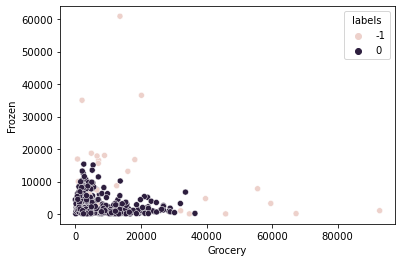

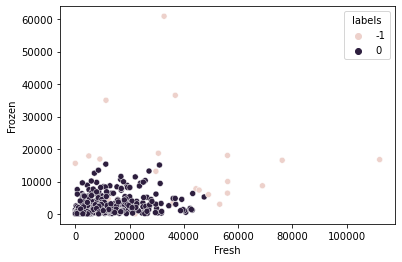

In [9]:
sns.scatterplot(df.Grocery, df.Frozen, hue=df.labels)
plt.show()

sns.scatterplot(df.Fresh, df.Frozen, hue=df.labels)
plt.show()


Text(0.5, 0, 'Grocery')

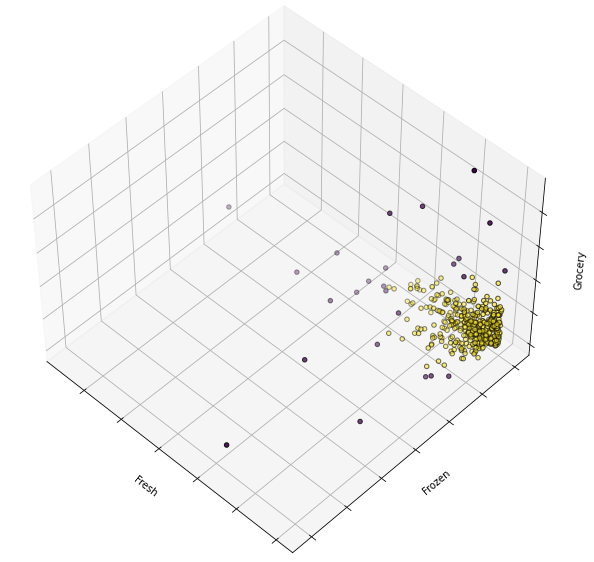

In [10]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.Fresh, df.Frozen, df.Grocery,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Fresh')
ax.set_ylabel('Frozen')
ax.set_zlabel('Grocery')

In [11]:
df.head(1)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Grocery,Scaled_Frozen,Scaled_Fresh,labels
0,2,3,12669,9656,7561,214,2674,1338,0.081464,0.003106,0.11294,0


In [12]:
# Cluster on all or a selected subset of features
ChanDetReg = df[['Channel', 'Detergents_Paper', 'Region']]
ChanDetReg.head(2)

,Channel,Detergents_Paper,Region
0,2,2674,3
1,2,3293,3


In [13]:
# Make the scaler
scaler = MinMaxScaler()

# Fit the scaler
scaler.fit(ChanDetReg)

# Use the scaler
ChanDetReg = scaler.transform(ChanDetReg)
ChanDetReg


array([[1.        , 0.0654272 , 1.        ],
       [1.        , 0.08058985, 1.        ],
       [1.        , 0.08605232, 1.        ],
       ...,
       [1.        , 0.36346267, 1.        ],
       [0.        , 0.00404174, 1.        ],
       [0.        , 0.01161082, 1.        ]])

In [14]:
# Make the object
dbsc = DBSCAN(eps = .10, min_samples = 20)

# Fit the object
dbsc.fit(ChanDetReg)


DBSCAN(eps=0.1, min_samples=20)

In [15]:
# Now, let's add the scaled value columns back onto the dataframe
columns = ['Channel', 'Detergents_Paper', 'Region']
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(ChanDetReg, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])
df.head()


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Grocery,Scaled_Frozen,Scaled_Fresh,labels,Scaled_Channel,Scaled_Detergents_Paper,Scaled_Region
0,2,3,12669,9656,7561,214,2674,1338,0.081464,0.003106,0.112940,0,1.0,0.065427,1.0
1,2,3,7057,9810,9568,1762,3293,1776,0.103097,0.028548,0.062899,0,1.0,0.080590,1.0
2,2,3,6353,8808,7684,2405,3516,7844,0.082790,0.039116,0.056622,0,1.0,0.086052,1.0
3,1,3,13265,1196,4221,6404,507,1788,0.045464,0.104842,0.118254,0,0.0,0.012346,1.0
4,2,3,22615,5410,7198,3915,1777,5185,0.077552,0.063934,0.201626,0,1.0,0.043455,1.0


In [16]:
# Assign the cluster labels
# Recall that cluster labels don't have inherent meaning
# DBSCAN makes a cluster called -1 that contains the "noise" or outliers
df['labels'] = dbsc.labels_
df.labels.value_counts()

 1    211
 0     98
 2     59
-1     44
 3     28
Name: labels, dtype: int64

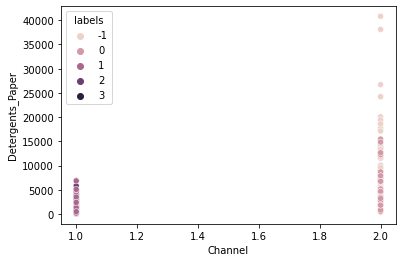

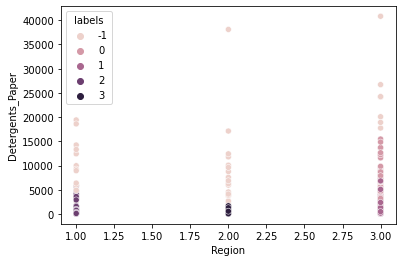

In [17]:
sns.scatterplot(df.Channel, df.Detergents_Paper, hue=df.labels)
plt.show()

sns.scatterplot(df.Region, df.Detergents_Paper, hue=df.labels)
plt.show()


Text(0.5, 0, 'Region')

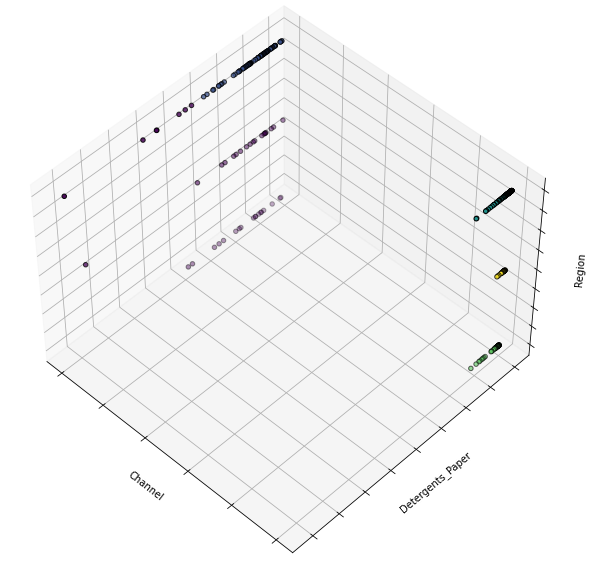

In [18]:
fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.Channel, df.Detergents_Paper, df.Region,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Channel')
ax.set_ylabel('Detergents_Paper')
ax.set_zlabel('Region')

###### Curriculum_logs...

In [27]:
df = pd.read_sql('SELECT * FROM logs;', get_db_url('curriculum_logs'))

In [28]:
df.head()

,date,time,path,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [29]:
df.date.value_counts()

2021-03-19    3104
2021-04-12    2446
2021-03-25    2369
2020-09-08    2304
2021-03-16    2298
              ... 
2018-12-29      32
2018-12-22      30
2018-12-30      21
2019-07-04      16
2018-12-23      10
Name: date, Length: 1182, dtype: int64

In [40]:
for path in df:
    display(path)

'date'

'time'

'path'

'user_id'

'cohort_id'

'ip'